In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [12]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
from datetime import datetime, timedelta

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
from sqlalchemy.ext.automap import automap_base
Base = automap_base()
Base.prepare(engine, reflect=True)
# reflect the tables


/var/folders/r6/yhgds1l94vl2k1823y88zj4r0000gn/T/ipykernel_83712/2095057606.py:4: SADeprecationWarning: The AutomapBase.prepare.reflect parameter is deprecated and will be removed in a future release.  Reflection is enabled when AutomapBase.prepare.autoload_with is passed.
  Base.prepare(engine, reflect=True)


In [7]:
# View all of the classes that automap found
Base.classes.keys()

['station', 'measurement']

In [8]:
# Save references to each table
Station = Base.classes.station
Measurement = Base.classes.measurement

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [10]:
# Find the most recent date in the data set.
most_recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
most_recent_date = most_recent_date[0]
print(f"Most recent date in the dataset: {most_recent_date}")

Most recent date in the dataset: 2017-08-23


Date one year ago: 2016-08-23 00:00:00


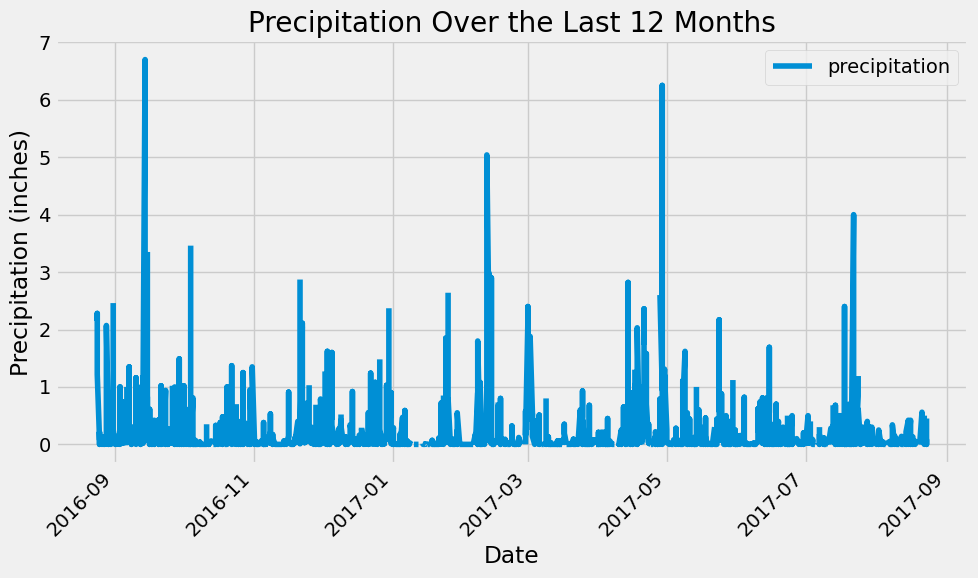

In [13]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
most_recent_date_dt = datetime.strptime(most_recent_date, '%Y-%m-%d')
one_year_ago = most_recent_date_dt - timedelta(days=365)
print(f"Date one year ago: {one_year_ago}")

# Perform a query to retrieve the data and precipitation scores
precipitation_data = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= one_year_ago).all()


# Save the query results as a Pandas DataFrame. Explicitly set the column names
precipitation_df = pd.DataFrame(precipitation_data, columns=['date', 'precipitation'])


# Sort the dataframe by date
precipitation_df['date'] = pd.to_datetime(precipitation_df['date'])
precipitation_df = precipitation_df.sort_values('date')

# Use Pandas Plotting with Matplotlib to plot the data
precipitation_df.plot(x='date', y='precipitation', figsize=(10,6), title='Precipitation Over the Last 12 Months')
plt.xlabel('Date')
plt.ylabel('Precipitation (inches)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [14]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary_stats = precipitation_df['precipitation'].describe()
print(summary_stats)

count    2015.000000
mean        0.176462
std         0.460288
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: precipitation, dtype: float64


# Exploratory Station Analysis

In [15]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(func.count(Measurement.station)).distinct().all()
print(f"Total number of stations: {total_stations[0][0]}")

Total number of stations: 19550


In [17]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
total_stations = session.query(func.count(Measurement.station)).distinct().all()
print(f"Total number of stations: {total_stations[0][0]}")
station_activity = session.query(Measurement.station, func.count(Measurement.station)) \
    .group_by(Measurement.station) \
    .order_by(func.count(Measurement.station).desc()) \
    .all()
print("Stations and observation counts in descending order:")
for station, count in station_activity:
    print(f"Station: {station}, Count: {count}")
    most_active_station = station_activity[0][0]
print(f"\nMost active station: {most_active_station}")



Total number of stations: 19550
Stations and observation counts in descending order:
Station: USC00519281, Count: 2772
Station: USC00519397, Count: 2724
Station: USC00513117, Count: 2709
Station: USC00519523, Count: 2669
Station: USC00516128, Count: 2612
Station: USC00514830, Count: 2202
Station: USC00511918, Count: 1979
Station: USC00517948, Count: 1372
Station: USC00518838, Count: 511

Most active station: USC00519281


In [18]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station = station_activity[0][0]
print(f"\nMost active station: {most_active_station}")


Most active station: USC00519281



Temperature stats for the most active station (ID: USC00519281):
Lowest Temperature: 54.0
Highest Temperature: 85.0
Average Temperature: 71.66378066378067


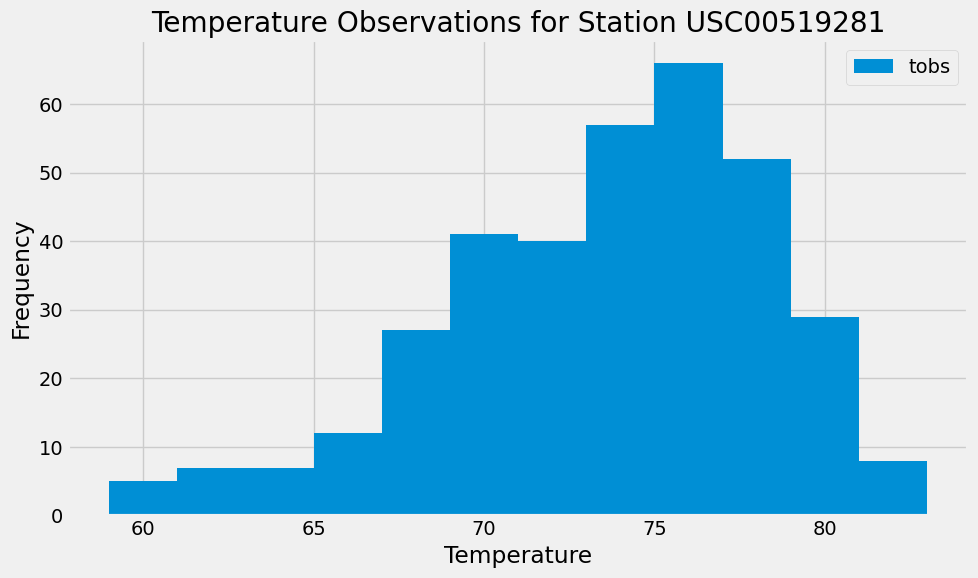

In [20]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temperature_stats = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)) \
    .filter(Measurement.station == most_active_station) \
    .all()

print(f"\nTemperature stats for the most active station (ID: {most_active_station}):")
print(f"Lowest Temperature: {temperature_stats[0][0]}")
print(f"Highest Temperature: {temperature_stats[0][1]}")
print(f"Average Temperature: {temperature_stats[0][2]}")
last_year_tobs = session.query(Measurement.date, Measurement.tobs) \
    .filter(Measurement.station == most_active_station) \
    .filter(Measurement.date >= one_year_ago) \
    .all()
tobs_df = pd.DataFrame(last_year_tobs, columns=['date', 'tobs'])
tobs_df.plot(kind='hist', y='tobs', bins=12, figsize=(10,6), title=f'Temperature Observations for Station {most_active_station}')
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()


# Close Session

In [21]:
# Close Session
session.close()